In [0]:
!pip install tensorflow-gpu
!pip install tqdm
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 516.2MB 24kB/s 
     |████████████████████████████████| 40kB 2.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=5ef3b6ba285ed9446378ec01d9529f4e5d3c007655b4e3c392480d97d08d57f6
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=93a014418f61979d04b015b8b84c173f3a0b54f4daed4203a8ad1b6099ea03d8
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=231405d7fcffbd89b547df0c08795f13e84b540b537fc549261ed41b18e2d55a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████

In [0]:
import os
import math
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import bert
from tqdm.notebook import tqdm
from tensorflow import keras
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Download the dataset file stored on google drive.
!gdown --id 19WPpy54EHgGb8vxY6mqj_JDlX0Zc-RsI --output data.csv

Downloading...
From: https://drive.google.com/uc?id=19WPpy54EHgGb8vxY6mqj_JDlX0Zc-RsI
To: /content/data.csv
1.35GB [00:07, 192MB/s]


In [0]:
# Load the dataset into a dataframe
dataframe = pd.read_csv("data.csv")

In [0]:
# Set the dataframe to 20,000 values.
final_dataframe = dataframe[:20000]

# A train/test split of 80%, 20% is used here.
data_split = 0.2
train, test = train_test_split(final_dataframe, test_size=data_split)


In [0]:
# To visualise the dataset.
train.head()

,rating,title,review
15460,2,A tentative beginning,"Though this album has three great singles, it ..."
11803,1,another American Idol disaster,Why don't you people buy albums by REAL artist...
6622,3,the demi-penultimate,Whilst being a superbly laid out reference for...
1799,3,great but disc was scratched,I got this as a Valentines Day gift for my fia...
19704,4,"Good, clean fun",The body of the kit feels a little cheap and f...


Total Reviews:  16000


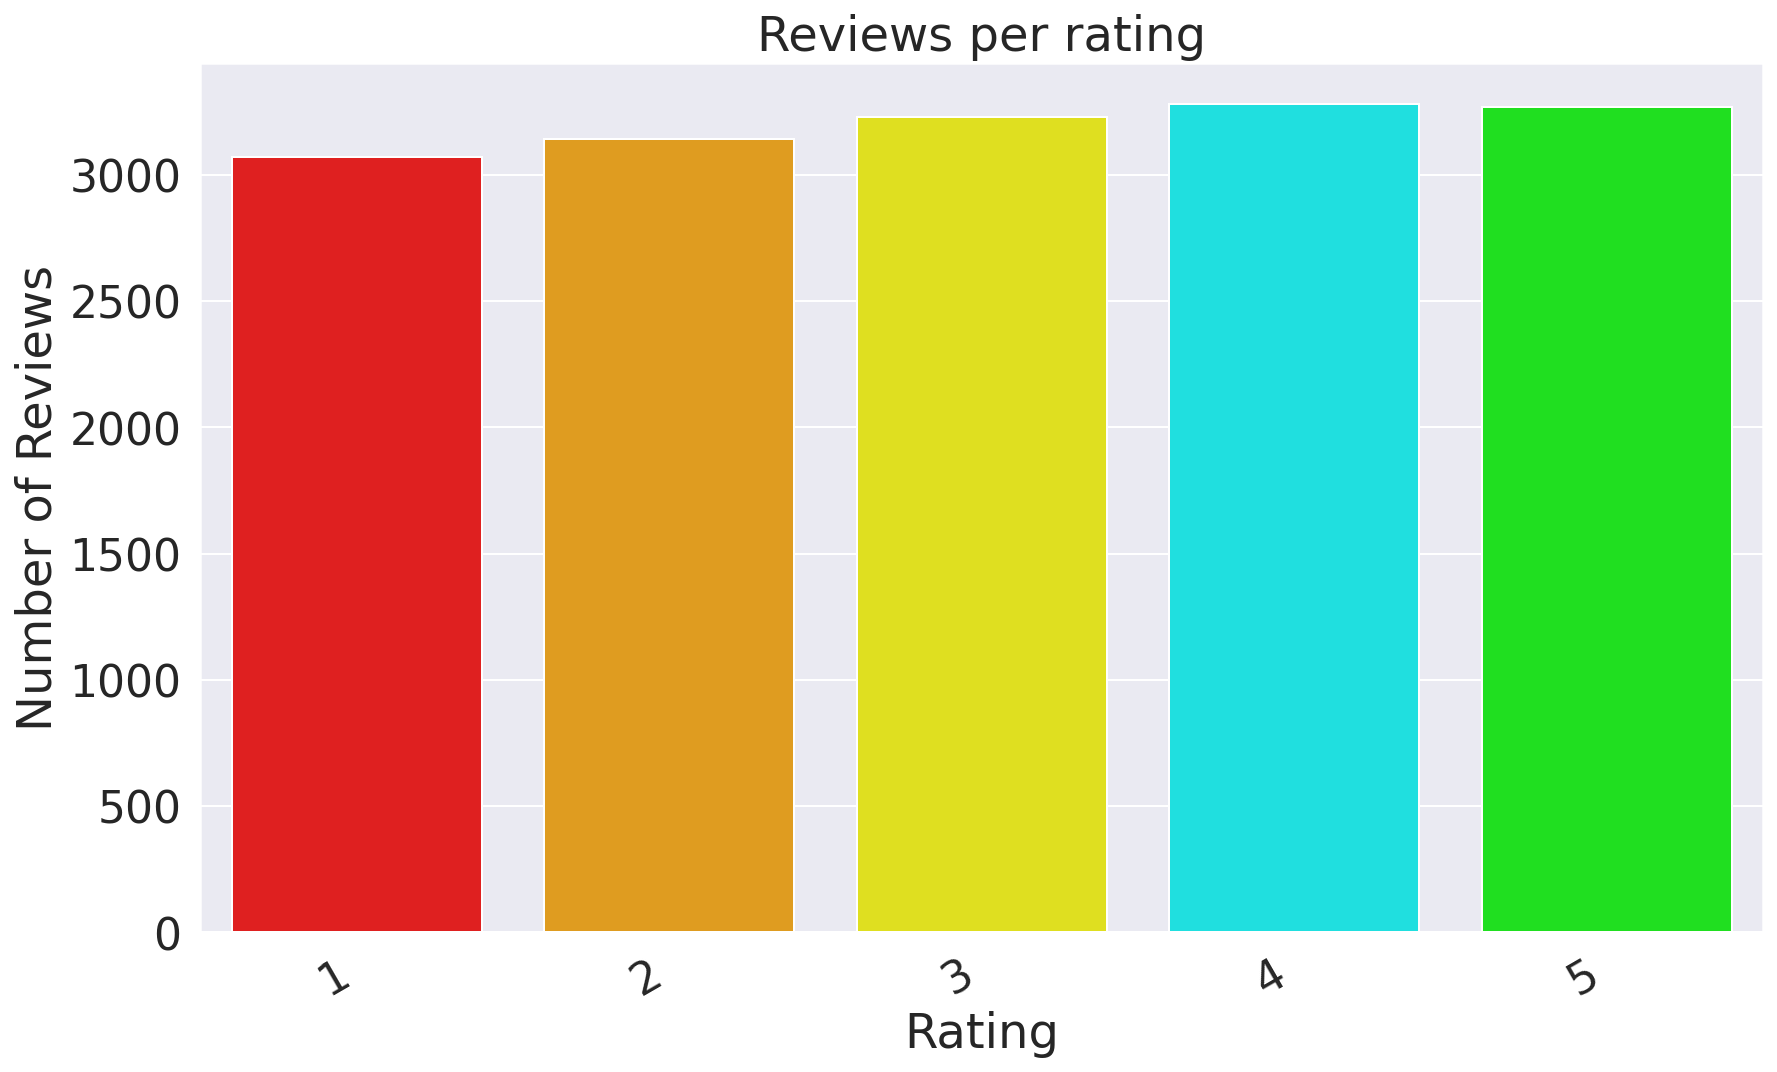

In [0]:
# Outputs the number of reviews by review type to understand the spread of review ratings in the set.
sns.set(font_scale=2, rc={'figure.figsize':(14,8)})
sns.set_palette(sns.color_palette(["#FF0000", "#FFA500", "#FFFF00", "#00FFFF", "#00FF00"]))
chart = sns.countplot(train.rating)
plt.title("Reviews per rating")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');
chart.set(xlabel= "Rating", ylabel="Number of Reviews")

total_reviews = len(train.rating)
print("Total Reviews: ", total_reviews)

In [0]:
# Retreive the Uncased BERT-Base model.
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-05-26 08:47:00--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  81.4MB/s    in 4.7s    

2020-05-26 08:47:05 (82.0 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [0]:
# Unpacking the bert model.
!unzip uncased_L-12_H-768_A-12.zip
os.makedirs("bert", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ bert

bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("bert/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
# Called on the un-processed dataset.
def get_data(train, test, tokenizer: FullTokenizer, classes, max_seq_length_override=256):
    # Finds the max sequence length of the input data.
    max_seq_length = 0
    print("Processing training data...")
    train_x, train_y, max_seq_length = process_data(train, max_seq_length)
    print("Processing testing data...")
    test_x, test_y, max_seq_length = process_data(test, max_seq_length)

    # Ensure the overriden value is only used if the sequence length of the dataset exceeds it.
    max_seq_length = min(max_seq_length, max_seq_length_override)

    # Pads the token ids from the previous step
    train_x = pad_data(train_x, max_seq_length)
    test_x = pad_data(test_x, max_seq_length)

    return ((train_x, train_y), (test_x, test_y)), max_seq_length

def process_data(dataframe, max_seq_length):
    x, y = [], []
    # Progress bar used when processing a large dataset.
    with tqdm(total=total_reviews) as pbar:
      for _, row in dataframe.iterrows():
          text, label = row["review"], row["rating"]
          #Tokenize the x labels
          tokens = tokenizer.tokenize(text)
          # Prepend [CLS] and append [SEP] to the tokenized x.
          tokens = ["[CLS]"] + tokens + ["[SEP]"]
          # Convert the tokens to ids.
          token_ids = tokenizer.convert_tokens_to_ids(tokens)
          # Update max sequence length if it is a new max value.
          max_seq_length = max(max_seq_length, len(token_ids))
          x.append(token_ids)
          y.append(classes.index(label))
          pbar.update(1)
    return np.array(x), np.array(y), max_seq_length

def pad_data(ids, max_seq_length):
    x_new = []
    for input_ids in ids:
        print(input_ids)
        input_ids = input_ids[:min(len(input_ids), max_seq_length - 2)]
        print(input_ids)
        input_ids = input_ids + [0] * (max_seq_length - len(input_ids))
        print(input_ids)
        x_new.append(np.array(input_ids))
    return np.array(x_new)

In [0]:
def create_model(max_seq_length, bert_ckpt_file):

  # Read in bert configuration from file and apply it to bert model layer
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_length, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  # Flattens the middle dimension (max sequence length) input layer, ignores the first and last dimension. Eg. (None, 196, 768) -> (None, 768).
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  # Dropout used to prevent overfitting.
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  # 768 used as this is the default hidden size set in the config.
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  # Second dropout layer.
  logits = keras.layers.Dropout(0.5)(logits)
  # Output layer, softmax used as we want classification. Outputs probabilities for each rating that all add up to 1.
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  # Load model.
  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_length))

  # Load the pre-trained weights so we can fine-tune the model to the dataset.
  load_stock_weights(bert, bert_ckpt_file)
  return model

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
# Ratings 1-5 stored in a list.
classes = train.rating.unique().tolist()
((X_train, y_train), (X_test, y_test)), max_seq_length = get_data(train, test, tokenizer, classes, max_seq_length_override=196)

Processing training data...



Processing testing data...



Padding X train and test...


In [0]:
model = create_model(max_seq_length, bert_ckpt_file)
model.summary()

bert shape (None, 196, 768)
Done loading 196 BERT weights from: bert/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f42087672b0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 196)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 196, 768)          

In [0]:
model.compile(
  # Adam recommended for BERT, if we are getting OOM errors then we should try a different optimizer.
  optimizer=keras.optimizers.Adam(2e-5),
  # Sparse is used instead of normal categorical cross entropy due to integers being used instead of one-hot encoding.
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [0]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=X_train, 
  y=y_train,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=4,
  callbacks=[tensorboard_callback]
)

Epoch 1/4
900/900 [==============================] - 1614s 2s/step - loss: 1.4711 - acc: 0.4043 - val_loss: 1.3829 - val_acc: 0.5119
Epoch 2/4
900/900 [==============================] - 1611s 2s/step - loss: 1.3632 - acc: 0.5291 - val_loss: 1.3910 - val_acc: 0.5056
Epoch 3/4
900/900 [==============================] - 1608s 2s/step - loss: 1.3173 - acc: 0.5785 - val_loss: 1.3721 - val_acc: 0.5281
Epoch 4/4
900/900 [==============================] - 1604s 2s/step - loss: 1.2824 - acc: 0.6173 - val_loss: 1.3589 - val_acc: 0.5387


In [0]:
# Save the pre-trained weights to use when predicting.
model.save_weights('bert_weights.h5')

In [0]:
print(history.history)

{'loss': [1.4710646867752075, 1.3631689548492432, 1.3173490762710571, 1.282421350479126], 'acc': [0.4043055474758148, 0.5290971994400024, 0.5785416960716248, 0.6172916889190674], 'val_loss': [1.3829082250595093, 1.391047477722168, 1.3721438646316528, 1.3589146137237549], 'val_acc': [0.5118749737739563, 0.5056250095367432, 0.528124988079071, 0.5387499928474426]}


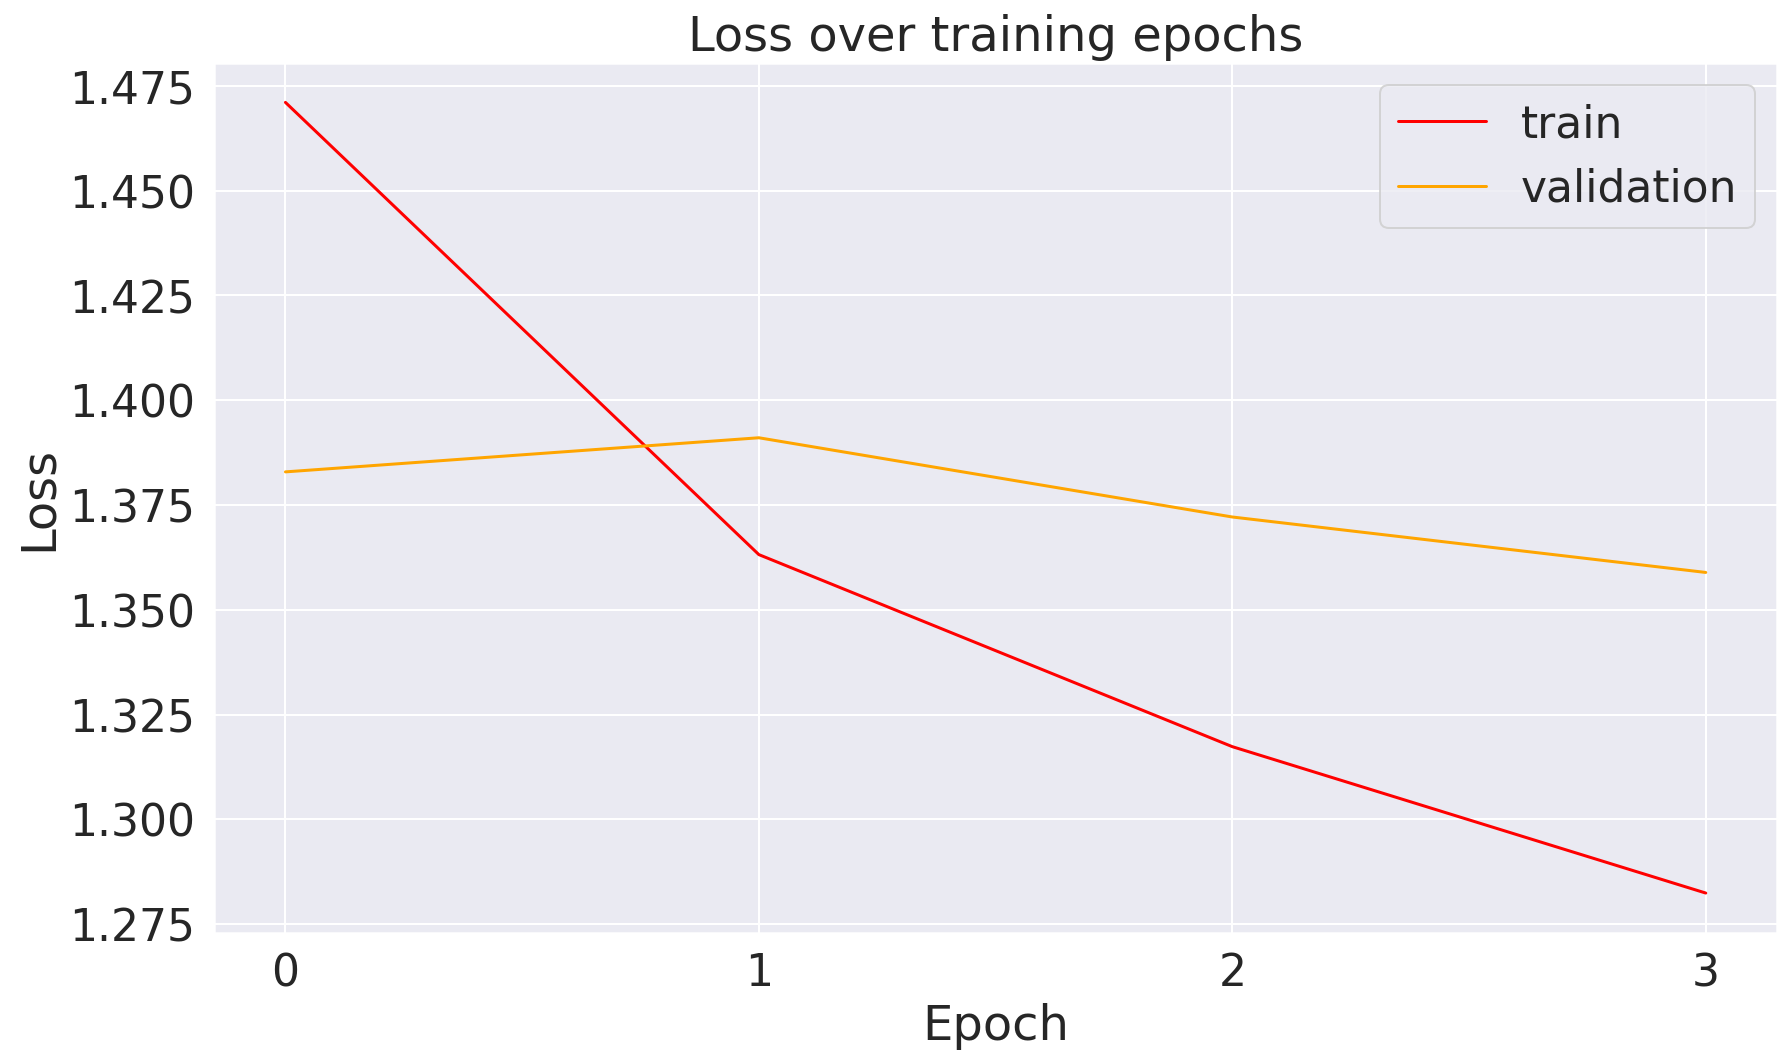

<Figure size 864x576 with 0 Axes>

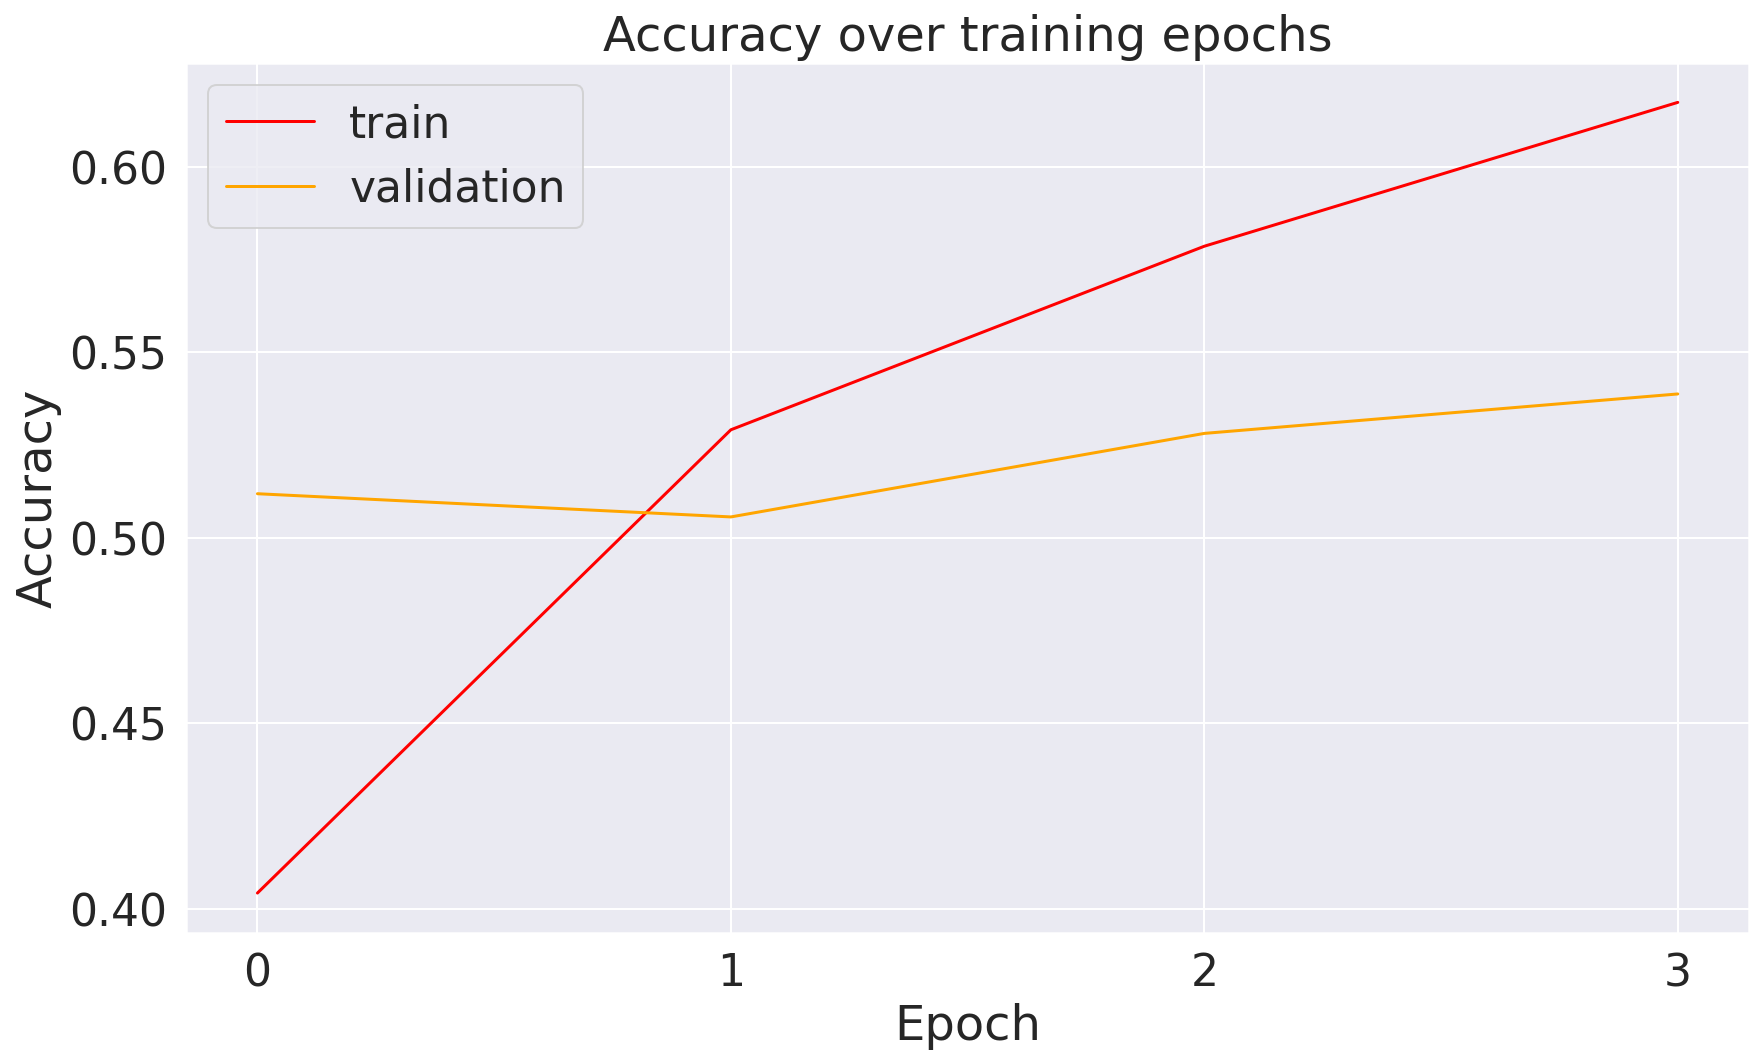

<Figure size 864x576 with 0 Axes>

In [0]:
#%load_ext tensorboard
#%tensorboard --logdir log

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.title('Loss over training epochs')
plt.figure(figsize=(12,8))
plt.show();

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.title('Accuracy over training epochs')
plt.figure(figsize=(12,8))
plt.show();

In [0]:
# Load the weights to ensure it is definitely using our fine-tuned model
model.load_weights('bert_weights.h5') 
# Predict using argmax to ensure we have a single label outputted (highest probability)
y_pred = model.predict(X_test).argmax(axis=-1)

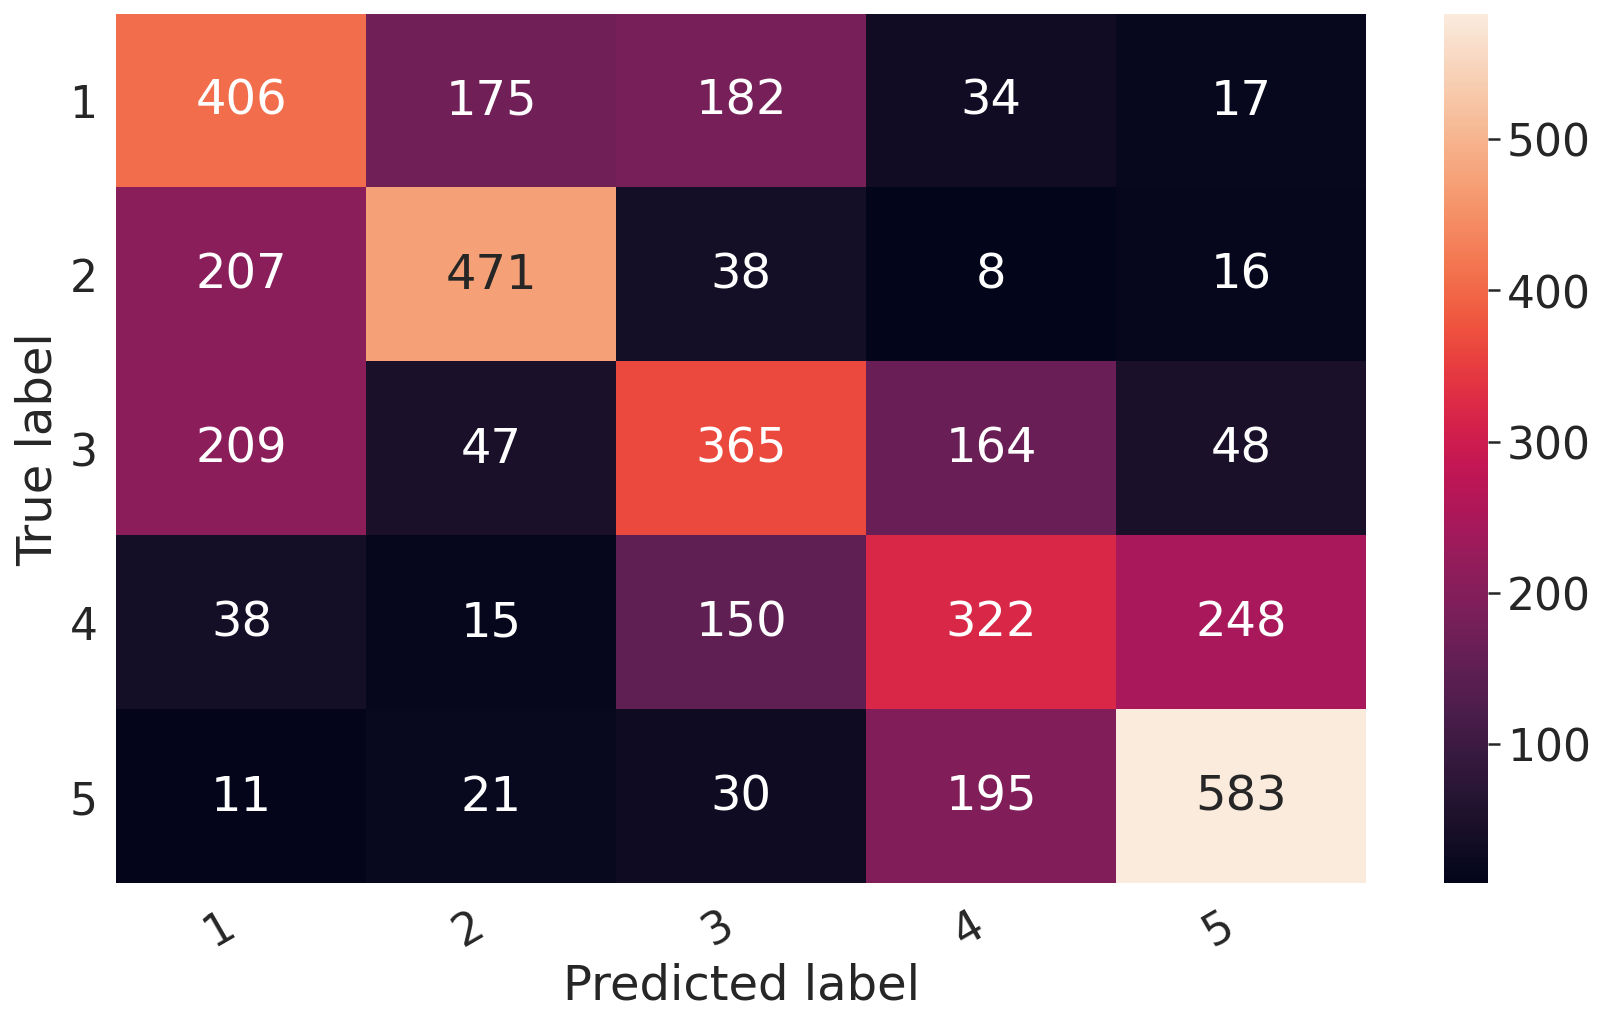

In [0]:
# Ratings start from 0 in this model so we need to use this array for the class labels
labels_cm = [0,1,2,3,4]
cm = confusion_matrix(y_test, y_pred, labels=labels_cm)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
# To give a valid output, the class labels need to be incremented by one to show the trained rating (1-5 used instead of 0-4 that the model recognises).
hmap.yaxis.set_ticklabels([1,2,3,4,5], rotation=0, ha='right')
hmap.xaxis.set_ticklabels([1,2,3,4,5], rotation=30, ha='right')

plt.ylabel('True label')
plt.xlabel('Predicted label');

In [0]:
# Test sentences to use.
sentences = [
  "This product is rubbish, would not recommend.",
  "Amazing! Loved this so much! Very Happy.",
  "This product was average.",
  "this product was ok, i enjoyed some aspects however, other parts were not up to standard",
  "I had only problems"
]

# Pre-process the test strings like training/test data has done.
pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
pred_token_ids = map(lambda tids: tids +[0]*(max_seq_length-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text: ", text)
  print("rating: ", classes[label])
  print()

text:  This product is rubbish, would not recommend.
rating:  1

text:  Amazing! Loved this so much! Very Happy.
rating:  5

text:  This product was average.
rating:  2

text:  this product was ok, i enjoyed some aspects however, other parts were not up to standard
rating:  3

text:  I had only problems
rating:  3

